# Deep Learning with PyTorch : Build a Generative Adversarial Network 

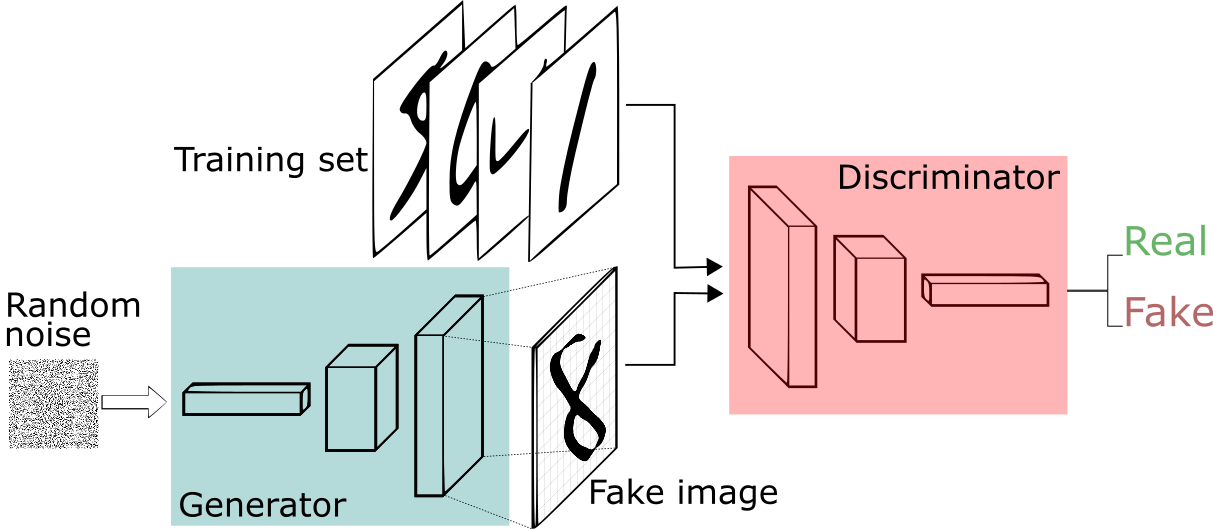

In [ ]:
import torch 
torch.manual_seed(42)
import numpy as np 
import matplotlib.pyplot as plt 

from tqdm.notebook import tqdm

# Configurations

In [ ]:
# Preparing the Device

device = 'cuda'
# cuda is for the transfering of the images to the GPU in Pytorch

batch_size = 128
# Useful in TrainLoadder and Traning Loops

noice_dim = 64
# Shape of Random Nice Vector going to pass the generator to produce the random data

lr = 0.0001
beta_1 = 0.5
beta_2 = 0.9

# These Variables are ging to be useful in the Adam Optimizer

epochs = 20
# for training loops

# Load MNIST Dataset 

In [ ]:
from torchvision import datasets, transforms as T

In [ ]:
train_augs = T.Compose([
        T.RandomRotation((-20,+20)),
    T.ToTensor()
])

In [ ]:
trainset = datasets.MNIST('MNIST/',download = True, train = True, transform = train_augs)

100%|██████████| 9912422/9912422 [00:00<00:00, 299000433.26it/s]

Extracting MNIST/MNIST/raw/train-images-idx3-ubyte.gz to MNIST/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 84828917.24it/s]


Extracting MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 168762601.19it/s]

Extracting MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 16130845.70it/s]


Extracting MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/MNIST/raw



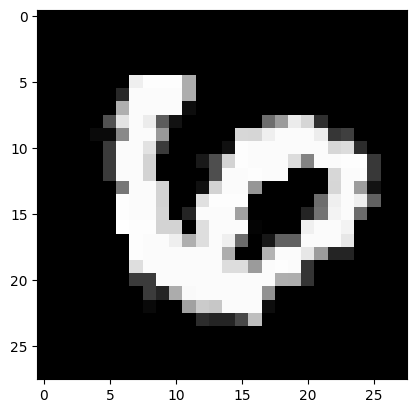

In [ ]:
image, label = trainset[9000]

plt.imshow(image.squeeze(),cmap='gray')

# Load Dataset Into Batches 

In [ ]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

In [ ]:
trainloader = DataLoader(trainset,  batch_size = batch_size, shuffle = True)

dataiter = iter(trainloader)

images, _ = dataiter.__next__()


In [ ]:
# 'show_tensor_images' : function is used to plot some of images from the batch

def show_tensor_images(tensor_img, num_images = 16, size=(1, 28, 28)):
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_images], nrow=4)
    plt.imshow(img_grid.permute(1, 2, 0).squeeze())
    plt.show()

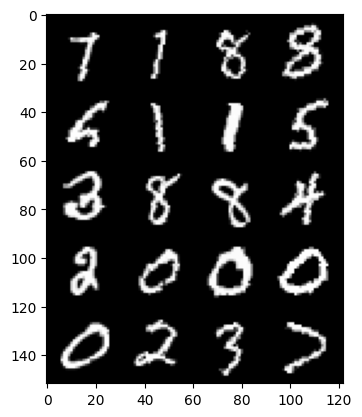

In [ ]:
show_tensor_images(images, num_images=20)

# Create Discriminator Network 

In [ ]:
#In case if torch summary is not installed 

!pip install torchsummary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from torchsummary import summary
from torch import nn

In [ ]:
'''

Network : Discriminator

input : (bs, 1, 28, 28)
      |                                                                                               ---- SUMMARY ----
      V
Conv2d( in_channels = 1, out_channels = 16, kernel_size = (3,3), stride = 2)                           #(bs, 16, 13, 13)
BatchNorm2d()                                                                                          #(bs, 16, 13, 13)
LeakyReLU()                                                                                            #(bs, 16, 13, 13)
      |
      V
Conv2d( in_channels = 16, out_channels = 32, kernel_size = (5,5), stride = 2)                          #(bs, 32, 5, 5)
BatchNorm2d()                                                                                          #(bs, 32, 5, 5)
LeakyReLU()                                                                                            #(bs, 32, 5, 5)
      |
      V
Conv2d( in_channels = 32, out_channels = 64, kernel_size = (5,5), stride = 2)                          #(bs, 64, 1, 1)
BatchNorm2d()                                                                                          #(bs, 64, 1, 1)
LeakyReLU()                                                                                            #(bs, 64, 1, 1)
      |
      V
Flatten()                                                                                              #(bs, 64)
Linear(in_features = 64, out_features = 1)                                                             #(bs, 1)

'''

'\n\nNetwork : Discriminator\n\ninput : (bs, 1, 28, 28)\n      |                                                                                               ---- SUMMARY ----\n      V\nConv2d( in_channels = 1, out_channels = 16, kernel_size = (3,3), stride = 2)                           #(bs, 16, 13, 13)\nBatchNorm2d()                                                                                          #(bs, 16, 13, 13)\nLeakyReLU()                                                                                            #(bs, 16, 13, 13)\n      |\n      V\nConv2d( in_channels = 16, out_channels = 32, kernel_size = (5,5), stride = 2)                          #(bs, 32, 5, 5)\nBatchNorm2d()                                                                                          #(bs, 32, 5, 5)\nLeakyReLU()                                                                                            #(bs, 32, 5, 5)\n      |\n      V\nConv2d( in_channels = 32, out_channels = 64, kernel

In [ ]:
def get_disc_block(in_channels, out_channels,kernal_size, stride):
  return nn.Sequential(
      nn.Conv2d(in_channels, out_channels,kernal_size, stride),
      nn.BatchNorm2d(out_channels),
      nn.LeakyReLU(0.2)
  )

In [ ]:
class Discriminator(nn.Module):

  def __init__(self):
    super(Discriminator,self).__init__()
    self.block_1 = get_disc_block(1,16,(3,3),2)
    self.block_2 = get_disc_block(16,32,(5,5),2)
    self.block_3 = get_disc_block(32,64,(5,5),2)

    self.flatten = nn.Flatten()
    self.linear = nn.Linear(in_features=64,out_features=1)

  def forward(self,images):

      x1 = self.block_1(images)
      x2 = self.block_2(x1)
      x3 = self.block_3(x2)

      x4 = self.flatten(x3)
      x5 = self.linear(x4)
      return x5





In [ ]:
D = Discriminator()
D.to(device)

summary(D,input_size=(1,28,28))

RuntimeError: ignored

# Create Generator Network 

In [ ]:
'''

Network : Generator 

z_dim = 64
input : (bs,z_dim)

      |
      | Reshape
      V

input : (bs, channel, height, width) -> (bs, z_dim , 1 , 1) 
      |                                                                                               ---- SUMMARY ----
      V
ConvTranspose2d( in_channels = z_dim, out_channels = 256, kernel_size = (3,3), stride = 2)             #(bs, 256, 3, 3)
BatchNorm2d()                                                                                          #(bs, 256, 3, 3)
ReLU()                                                                                                 #(bs, 256, 3, 3)
      |
      V
ConvTranspose2d( in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)               #(bs, 128, 6, 6)
BatchNorm2d()                                                                                          #(bs, 128, 6, 6)
ReLU()                                                                                                 #(bs, 128, 6, 6)
      |
      V
ConvTranspose2d( in_channels = 128, out_channels = 64, kernel_size = (3,3), stride = 2)                #(bs, 64, 13, 13)
BatchNorm2d()                                                                                          #(bs, 64, 13, 13)
ReLU()                                                                                                 #(bs, 64, 13, 13)
      |
      V
ConvTranspose2d( in_channels = 64, out_channels = 1, kernel_size = (4,4), stride = 2)                  #(bs, 1, 28, 28)
Tanh()                                                                                                 #(bs, 1, 28, 28)

'''

In [ ]:
def get_gen_block(in_channels , out_channels, kernel_size, stride, final_block = False):
  if final_block == True:
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels , out_channels, kernel_size, stride),
        nn.Tanh()
    )
  else:  
    return nn.Sequential(
      nn.ConvTranspose2d(in_channels, out_channels , kernel_size , stride ),
      nn.BatchNorm2d(out_channels),
      nn.ReLU()
  )

In [ ]:
class Generator(nn.Module):

  def __init__(self,noice_dim):
    super(Generator,self).__init__()

    self.noice_dim = noice_dim
    self.block_1   = get_gen_block(noice_dim, 256,(3,3),2)
    self.block_2   = get_gen_block(256,128,(4,4),1)
    self.block_3   = get_gen_block(128,64,(3,3),2)

    self.block_4   = get_gen_block(64,1,(4,4),2,final_block=True)


  def forward(self,r_noice_vec):


    x  = r_noice_vec.view(-1,self.noice_dim,1,1)
    
    x1 = self.block_1(x)

    x2 = self.block_2(x1)
    x3 = self.block_3(x2)
    x4 = self.block_4(x3)

    return x4

In [ ]:
G = Generator(noice_dim)
G.to(device)

summary(G,input_size=(1,noice_dim))

In [ ]:
# Replace Random initialized weights to Normal weights  

def weights_init(m):  
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
        nn.init.constant_(m.bias, 0)

In [ ]:
D = D.apply(weights_init)
G = G.apply(weights_init)

# Create Loss Function and Load Optimizer

In [ ]:
def real_loss( disc_pred):
  criterion    = nn.BCEWithLogitsLoss()
  ground_truth = torch.ones_like(disc_pred)
  loss         = criterion(disc_pred,ground_truth)
  return loss

def fake_loss(disc_pred):
  criterion     = nn.BCEWithLogitsLoss()
  ground_truth  = torch.zeros_like(disc_pred)
  loss          = criterion(disc_pred,ground_truth)
  return loss


In [ ]:
D_opt = torch.optim.Adam(D.parameters(),lr=lr,betas=(beta_1,beta_2))

G_opt = torch.optim.Adam(G.parameters(),lr=lr,betas=(beta_1,beta_2))

# Training Loop 

In [ ]:
for i in range(epochs):
  total_d_loss = 0.0
  total_g_loss = 0.0

  for real_img,_ in tqdm(trainloader):
    real_img = real_img.to(device)
    noice    = torch.randn(batch_size,noice_dim,device=device)

    D_opt.zero_grad()
    fake_img      = G(noice)
    D_pred        = D(fake_img)
    D.fake_loss   = fake_loss(D_pred)

    D_pred        = D(real_img)
    D.real_loss   = real_loss(D_pred)

    D.loss        = (D.fake_loss + D.real_loss )/2

    total_d_loss += D.loss.item()

    D.loss.backward()
    D_opt.step()


    # For Generator 
    G_opt.zero_grad()

    noice       =  torch.randn(batch_size, noice_dim ,device=device)

    fake_img    = G(noice)

    D_pred      = D(fake_img)

    G.loss      = real_loss(D_pred)

    total_g_loss+= G.loss.item()

    G.loss.backward()

    G_opt.step()

  avg_g_total =   total_g_loss/len(trainloader)
  avg_d_total =   total_d_loss/len(trainloader)




  print("Epoches : {} | D_loss : {}  | G_loss : {}".format(i+1,avg_d_total,avg_g_total))
  show_tensor_images(fake_img)







In [ ]:
# Run after training is completed.
# Now you can use Generator Network to generate handwritten images

noice = torch.randn(batch_size, noice_dim, device = device)
generated_image = G(noice)

show_tensor_images(generated_image)

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya

In [ ]:
torch.save(G, "generator_model.pth")